# Merge Sort

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Appendix A

Copyright 2017 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import os
import string
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import thinkplot

import matplotlib.pyplot as plt

### Empirical order of growth

Sometimes we can figure out what order of growth a function belongs to by running it with a range of problem sizes and measuring the run time.

To measure runtimes, we'll use `etime`, which uses `os.times` to compute the total time used by a process, including "user time" and "system time".  User time is time spent running your code; system time is time spent running operating system code on your behalf.

In [8]:
def etime():
    """Measures user and system time this process has used.

    Returns the sum of user and system time."""
    user, sys, chuser, chsys, real = os.times()
    return user+sys

`time_func` takes a function object and a problem size, `n`, runs the function, and returns the elapsed time.

In [9]:
def time_func(func, n):
    """Run a function and return the elapsed time.
    
    func: function
    n: problem size
    
    returns: user+sys time in seconds
    """
    start = etime()
    func(n)
    end = etime()
    elapsed = end - start
    return elapsed

`run_timing_test` takes a function, runs it with a range of problem sizes, and returns two lists: problem sizes and times.

In [10]:
def run_timing_test(func, max_time=1):
    """Tests the given function with a range of values for n.
    
    func: function object

    returns: list of ns and a list of run times.
    """
    ns = []
    ts = []
    for i in range(6, 28):
        n = 2**i
        t = time_func(func, n)
        print(n, t)
        if t > 0:
            ns.append(n)
            ts.append(t)
        if t > max_time:
            break

    return ns, ts

`fit` takes the lists of ns and ts and fits it with a curve of the form `a * n**exp`, where `exp` is a given exponent and `a` is chosen so that the line goes through a particular point in the sequence, usually the last. 

In [12]:
def fit(ns, ts, exp=1.0, index=-1):
    """Fits a curve with the given exponent.
    
    ns: sequence of problem sizes
    ts: sequence of times
    exp: exponent of the fitted curve
    index: index of the element the fitted line should go through
    
    returns: sequence of fitted times

    
    """
    # Use the element with the given index as a reference point, 
    # and scale all other points accordingly.
    nref = ns[index]
    tref = ts[index]

    tfit = []
    for n in ns:
        ratio = n / nref
        t = ratio**exp * tref
        tfit.append(t)

    return tfit

`plot_timing_test` plots the results.

In [13]:
def plot_timing_test(ns, ts, label='', color='blue', exp=1.0, scale='log'):
    """Plots data and a fitted curve.

    ns: sequence of n (problem size)
    ts: sequence of t (run time)
    label: string label for the data curve
    color: string color for the data curve
    exp: exponent (slope) for the fitted curve
    """
    tfit = fit(ns, ts, exp)
    plt.plot(ns, tfit, color='0.7', linewidth=2, linestyle='dashed')
    plt.plot(ns, ts, 's-', label=label, color=color, alpha=0.5, linewidth=3)
    plt.xlabel('Problem size (n)')
    plt.ylabel('Runtime (seconds)')
    plt.xscale(scale)
    plt.yscale(scale)
    plt.legend()

For small values of `n`, the runtime is so short that we're probably not getting an accurate measurement of just the operation we're interested in.  But as `n` increases, runtime seems to converge to a line with slope 1.  

That suggests that performing append `n` times is linear, which suggests that a single append is constant time.  

### Comparing sort algorithms

NumPy provides implementations of three sorting algorithms, quicksort, mergesort, and heapsort.

Read about each of these algorithms to see what order of growth they belong to.

Now let's see if we can characterize their asymptotic behavior.



64 0.0
128 0.0
256 0.0
512 0.0
1024 0.0
2048 0.0
4096 0.0
8192 0.0
16384 0.010000000000000009
32768 0.010000000000000009
65536 0.010000000000000009
131072 0.040000000000000036
262144 0.039999999999999813
524288 0.06000000000000005
1048576 0.14000000000000035
2097152 0.2699999999999996
4194304 0.56
8388608 1.15


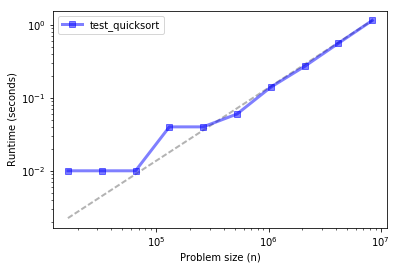

In [7]:
def test_quicksort(n):
    xs = np.random.normal(size=n)
    xs.sort(kind='quicksort')

ns, ts = run_timing_test(test_quicksort)
plot_timing_test(ns, ts, 'test_quicksort', exp=1)

Quicksort is hard to distinguish from linear, up to about 10 million elements.

64 0.0
128 0.0
256 0.0
512 0.0
1024 0.0
2048 0.0
4096 0.0
8192 0.0
16384 0.0
32768 0.009999999999999787
65536 0.010000000000000675
131072 0.019999999999999574
262144 0.03000000000000025
524288 0.0699999999999994
1048576 0.16000000000000014
2097152 0.3099999999999996
4194304 0.6400000000000006
8388608 1.3899999999999997


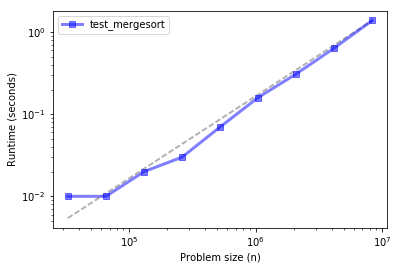

In [8]:
def test_mergesort(n):
    xs = np.random.normal(size=n)
    xs.sort(kind='mergesort')

ns, ts = run_timing_test(test_mergesort)
plot_timing_test(ns, ts, 'test_mergesort', exp=1)

Merge sort is similar, maybe with some upward curvature.

64 0.0
128 0.0
256 0.0
512 0.0
1024 0.0
2048 0.0
4096 0.0
8192 0.009999999999999787
16384 0.0
32768 0.0
65536 0.019999999999999574
131072 0.010000000000001563
262144 0.03999999999999915
524288 0.0600000000000005
1048576 0.129999999999999
2097152 0.34999999999999964
4194304 0.5600000000000005
8388608 1.25


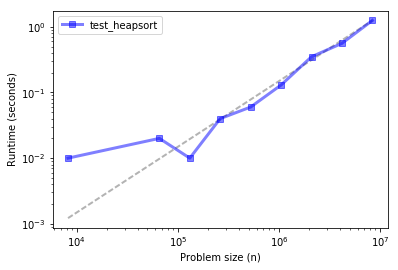

In [9]:
def test_heapsort(n):
    xs = np.random.normal(size=n)
    xs.sort(kind='heapsort')

ns, ts = run_timing_test(test_quicksort)
plot_timing_test(ns, ts, 'test_heapsort', exp=1)

The three methods are effectively linear over this range of problem sizes.

And their run times are about the same, with quicksort being the fastest, despite being the one with the worst asympotic performance in the worst case.

### Implementing Merge Sort



In [2]:
def merge_sort_norec(xs):
    N = len(xs)
    left = xs[:N//2]
    right = xs[N//2:]
    
    left.sort()
    right.sort()
    
    return merge(left, right)

This version breaks the array in half, uses `np.sort` to sort the two halves, then uses merge to put the halves together.

**Exercise:** Write a function called `merge` that takes two sorted NumPy arrays, `left` and `right`, and returns a new array that contains all elements from `left` and `right`, sorted.  (where "sorted" means in ascending order, or non-decreasing, to be more precise).

Note: this function is not hard to write, but it is notoriously difficult to get all of the edge cases right without making the function unreadable.  Take it as a challenge to write a version that is correct, concise, and readable.

In [3]:
from collections import deque

def merge(left, right):
    left_deque = deque(left)
    right_deque = deque(right)
    merged_list = []
    while left_deque and right_deque:
        if left_deque[0] < right_deque[0]:
            head = left_deque.popleft()
            merged_list.append(head)
        else:
            head = right_deque.popleft()
            merged_list.append(head)
    
    merged_list.extend(left_deque)
    merged_list.extend(right_deque)
    return merged_list
        
        

In [16]:
xs = np.random.random(10)
ys = np.random.random(10)
xs.sort()
ys.sort()
res = merge(xs, ys)
sorted(res) == res

[0.0086807043300912712, 0.060052199380459248, 0.09640334878700163, 0.15553632172667575, 0.16069075074211736, 0.26449222452373522, 0.31494377509321125, 0.34859724502347744, 0.35015254394549633, 0.35401730410136356, 0.41369291917951301, 0.41573566639771264, 0.43002662652834522, 0.65793476746386803, 0.66668089775532891, 0.68442492375807973, 0.71505330583504645, 0.81331662460837784, 0.8613711507008035, 0.92998284153889366]


True

**Exercise:**  Starting with `merge_sort_norec`, write a function called `merge_sort_rec` that's fully recursive; that is, instead of using `numpy.sort` to compute the DFTs of the halves, it should use `merge_sort_rec`.  Of course, you will need a base case to avoid an infinite recursion.



In [4]:
def merge_sort_rec(xs):
    N = len(xs)
    if N == 1:
        return xs
    else:
        left = xs[:N//2]
        right = xs[N//2:]
        return merge(merge_sort_rec(left), merge_sort_rec(right))

Test your method by running the code in the next cell, then use `test_merge_sort_rec`, below, to check the performance of your function.

In [6]:
xs = np.random.random(10)

res = merge_sort_rec(xs)
sorted(res) == res

True

64 0.0
128 0.0
256 0.0
512 0.0
1024 0.0
2048 0.009999999999999787
4096 0.03000000000000025
8192 0.040000000000000036
16384 0.0600000000000005
32768 0.13999999999999968
65536 0.2699999999999996
131072 0.75
262144 1.5100000000000007


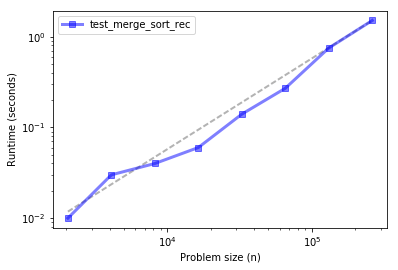

In [14]:
def test_merge_sort_rec(n):
    xs = np.random.normal(size=n)
    spectrum = merge_sort_rec(xs)

ns, ts = run_timing_test(test_merge_sort_rec)
plot_timing_test(ns, ts, 'test_merge_sort_rec', exp=1)

If things go according to plan, your implementation of merge sort should be close to linear, or a little steeper.